In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import accuracy, error_rate

from gzip import GzipFile

In [2]:
image_path = Path('../image-data/08-stacked-gray/')
image_path.ls()

[PosixPath('../image-data/08-stacked-gray/high'),
 PosixPath('../image-data/08-stacked-gray/medium'),
 PosixPath('../image-data/08-stacked-gray/low')]

In [3]:
class ImageItemList_XChannel(ImageList):
    def open(self, fname):
        with GzipFile(fname, 'r') as in_file:
            np_image = np.load(in_file).astype(np.float32)/255        
        return Image(pil2tensor(np_image, np.float32).float())

In [4]:
image_size = 256
batch_size = 64
tfms = get_transforms()

In [5]:
data = (ImageItemList_XChannel.from_folder(image_path, extensions='.gz')
       .split_by_rand_pct()
       .label_from_folder()
       .transform(tfms, size=image_size)
       .databunch(bs=batch_size)
       .normalize()) # Optional

In [6]:
data

ImageDataBunch;

Train: LabelList (4709 items)
x: ImageItemList_XChannel
Image (2, 256, 256),Image (2, 256, 256),Image (2, 256, 256),Image (2, 256, 256),Image (2, 256, 256)
y: CategoryList
high,high,high,high,high
Path: ../image-data/08-stacked-gray;

Valid: LabelList (1177 items)
x: ImageItemList_XChannel
Image (2, 256, 256),Image (2, 256, 256),Image (2, 256, 256),Image (2, 256, 256),Image (2, 256, 256)
y: CategoryList
high,low,low,medium,high
Path: ../image-data/08-stacked-gray;

Test: None

In [7]:
data.classes, data.c

(['high', 'low', 'medium'], 3)

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate], pretrained=False, callback_fns=ShowGraph)

In [9]:
learn.model[0][0] = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
learn.model.cuda();

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.002391,0.666898,0.644860,0.355140,00:21
1,0.792909,0.693834,0.669499,0.330501,00:19
2,0.668011,0.631139,0.678845,0.321155,00:19
3,0.560644,0.410227,0.790144,0.209856,00:19
4,0.461081,0.282937,0.881903,0.118097,00:20
5,0.367114,0.265129,0.892099,0.107901,00:19
6,0.290963,0.165015,0.927782,0.072218,00:19
7,0.254480,0.139349,0.950722,0.049278,00:19
8,0.201973,0.127953,0.949023,0.050977,00:19
9,0.172192,0.116560,0.958369,0.041631,00:18


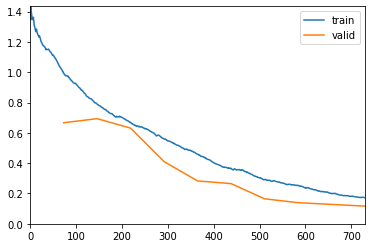

In [10]:
learn.fit_one_cycle(10)

In [11]:
learn.save('stage1-stacked-gray')

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

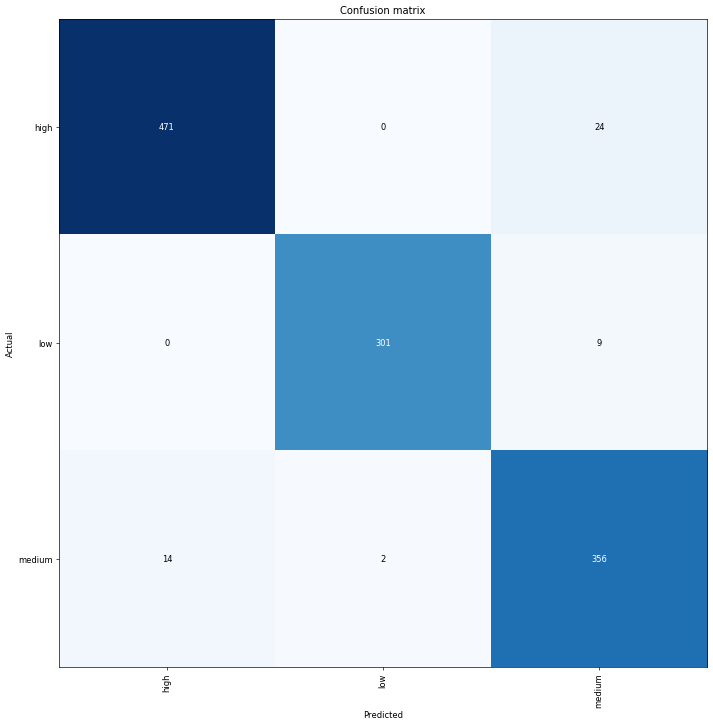

In [13]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.recorder.plot_losses()
x = plt.gca()
x.set_title('test')
plt.gcf().savefig('test.pdf')

In [14]:
from time import time

learn.load('stage1-stacked-gray')
learn.model.training = False

grass_path = Path('../image-data/grass/8-stacked-gray')

grass_path.ls()

[PosixPath('../image-data/grass/8-stacked-gray/high'),
 PosixPath('../image-data/grass/8-stacked-gray/medium'),
 PosixPath('../image-data/grass/8-stacked-gray/low')]

In [15]:
# Doing this in a loop to get running times

def open_stacked(fname):
    with GzipFile(fname, 'r') as in_file:
        np_image = np.load(in_file).astype(np.float32)/255        
    return Image(pil2tensor(np_image, np.float32).float())

clsses = ['high', 'medium', 'low']
totals = [0, 0, 0]
correct = [0, 0, 0]

total_time = 0

for clss_idx, clss in enumerate(clsses):
    grass_fnames = grass_path/clss
    print(grass_fnames)
    for grass_fname in grass_fnames.glob('*.gz'):
        
        img = open_stacked(grass_fname)
        
        tstart = time()
        pred = learn.predict(img)
        total_time += time() - tstart
        
        if str(pred[0]) == clss:
            correct[clss_idx] += 1
        totals[clss_idx] += 1
print('done')

../image-data/grass/8-stacked-gray/high
../image-data/grass/8-stacked-gray/medium
../image-data/grass/8-stacked-gray/low
done


In [16]:
print(correct)
print(totals)
print([c/t*100 for c, t in zip(correct, totals)])
print(sum(correct)/sum(totals)*100)
print(total_time)

[268, 97, 84]
[284, 295, 295]
[94.36619718309859, 32.88135593220339, 28.474576271186443]
51.37299771167048
6.341181516647339
